In [4]:
import pandas as pd
cnvs = pd.read_csv('merged_cnvs.txt', sep="\t", header=0, index_col=None, low_memory=False)
cnvs_genes = pd.read_csv('merged_cnvs_genes.txt', sep="\t", header=0, index_col=0)

In [5]:
metasamples = pd.read_excel('../Metadata2.xlsx')

# Keep only samples that are tumor-normal pair and labeled as included
df = metasamples.loc[(metasamples['INCLUDED'] == "Y")
                     & (metasamples['TUMOR_ONLY'] == "No")
                     & (metasamples['SAMPLE_TYPE'] != "gDNA")
                     & (metasamples['SAMPLE_TYPE'] != "PDX"),
                     ['PATIENT_ID', 'SAMPLE_ID']]
metasamples.index = metasamples['SAMPLE_ID']
meta_filtered = metasamples.reindex(df['SAMPLE_ID'].tolist())
SAMPLES = [x.strip() for x in df['SAMPLE_ID'] + '-' + df['PATIENT_ID']]
meta_filtered.index = SAMPLES

cnvs = cnvs.loc[:, cnvs.columns[0:3].to_list() + SAMPLES]
cnvs_genes = cnvs_genes.loc[:, SAMPLES]

In [6]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
import numpy as np
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib.patches import Patch
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

                            
scaled_cmp = ListedColormap(['darkblue', 'blue', 'white', 'red', 'darkred'])
relative_cmp = matplotlib.cm.bwr
figsize = (16,16) 
color_map = ["red", "green", "blue", "orange", "cyan", "yellow", "orchid", 
             "saddlebrown", "darkcyan", "gray", "darkred", "darkgreen", "darkblue", 
             "antiquewhite", "bisque", "black", "slategray", "gold", "floralwhite",
             "aliceblue", "plum", "cadetblue", "coral", "olive", "khaki", "lightsalmon"]

def plot_heatmap(data, meta, title, filename, col_cluster, row_cluster, scaled=True):
    meta = meta.reindex(data.index)
    mask = data < 0

    var1_colors = [color_map[0] if x == 'E' else color_map[1] for x in meta['VAR2']]
    var2_colors = [color_map[2] if x == 'BEFORE' else color_map[3] if x == 'AFTER' else (1,1,1) for x in meta['VAR1']]
    var3 = meta['VAR3'].copy()
    var3.loc[var3 == 'CR'] = color_map[4]
    var3.loc[var3 == 'PD'] = color_map[5]
    var3.loc[var3 == 'PR'] = color_map[6]
    var3.loc[var3 == 'long SD'] = color_map[7]
    var3.loc[var3 == 'short SD'] = color_map[8]
    var3_colors = var3.to_list()
    var7_colors = [color_map[9] if x == 'doblete' else color_map[10] for x in meta['VAR7']]

    ax = sns.clustermap(data,
                        mask=mask,
                        z_score=None,
                        cmap=scaled_cmp if scaled else relative_cmp,
                        rasterized=True,
                        metric='euclidean',
                        method='average',
                        yticklabels=1,
                        row_colors=[var1_colors, var2_colors, var3_colors, var7_colors],
                        col_cluster=col_cluster,
                        row_cluster=row_cluster,
                        vmax=0,
                        vmin=4)
    
    handles = [Patch(color=color_map[0], label='E'),
               Patch(color=color_map[1], label='F'),
               Patch(color=color_map[2], label='BEFORE'),
               Patch(color=color_map[3], label='AFTER'),
               Patch(color=color_map[4], label='CR'),
               Patch(color=color_map[5], label='PD'),
               Patch(color=color_map[6], label='PR'),
               Patch(color=color_map[7], label='long SD'),
               Patch(color=color_map[8], label='short SD'),
               Patch(color=color_map[9], label='doblete'),
               Patch(color=color_map[10], label='triplete')]
    ax.ax_heatmap.set_title(title, fontsize=12)
    ax.ax_heatmap.set_xlabel("Positions",fontsize=10)
    ax.ax_heatmap.set_ylabel("Samples", fontsize=10)
    ax.ax_heatmap.tick_params(labelsize=6)
    ax.cax.set_visible(True)
    ax.ax_row_dendrogram.legend(handles=handles, loc="upper left")
    ax.savefig(filename)
    
def plot_pca(x, y, colors, labels, title, filename):

    unique_colors = set(colors)
    color_values = [color_map[i] for i in unique_colors]
    colors = [color_map[i] for i in colors]

    fig, ax = plt.subplots(figsize=(12,12))
    sc = ax.scatter(x, y, 
                    c=colors, 
                    edgecolor="none", 
                    cmap=None, 
                    s=20)

    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_title(title, size=5)
    ax.legend([plt.Line2D((0, 1), (0, 0), color=x) for x in color_values],
              labels, loc="upper right", markerscale=1.0,
              ncol=1, scatterpoints=1, fontsize=5)
    fig.savefig(filename)

/Users/jfnavarro/anaconda3/envs/hla/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jfnavarro/anaconda3/envs/hla/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jfnavarro/anaconda3/envs/hla/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jfnavarro/anaconda3/envs/hla/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jfnavarro/anaconda3/envs/hla/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastclus

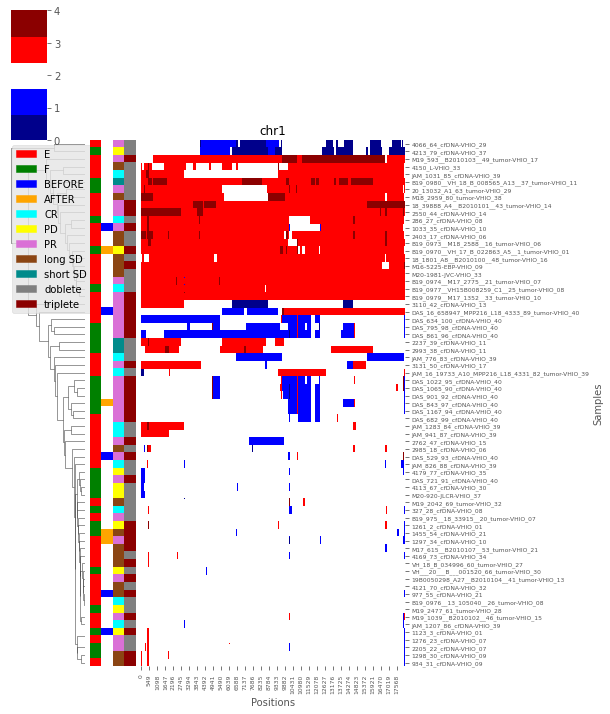

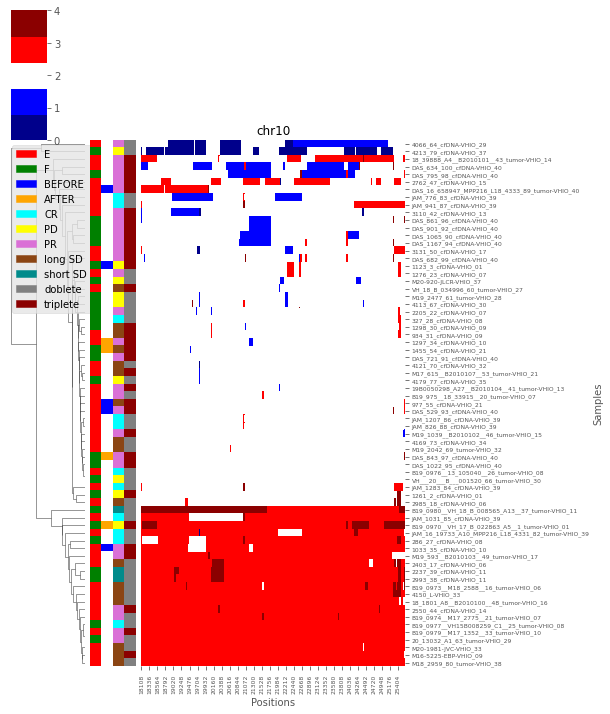

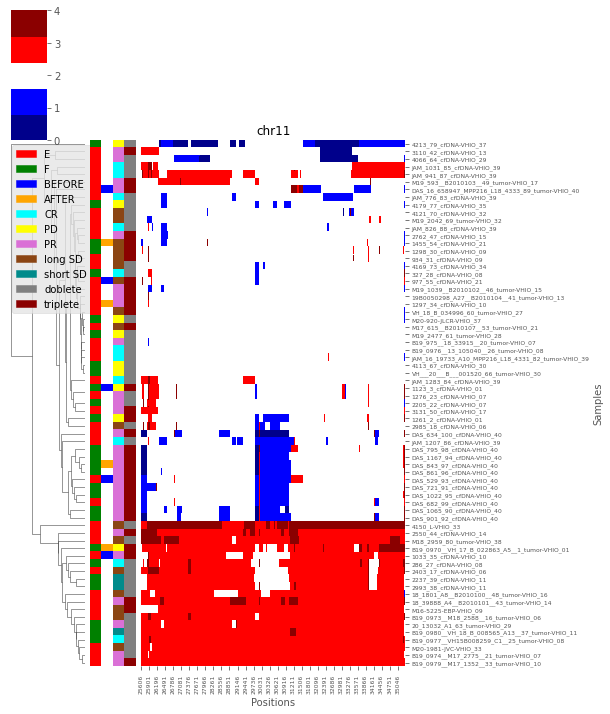

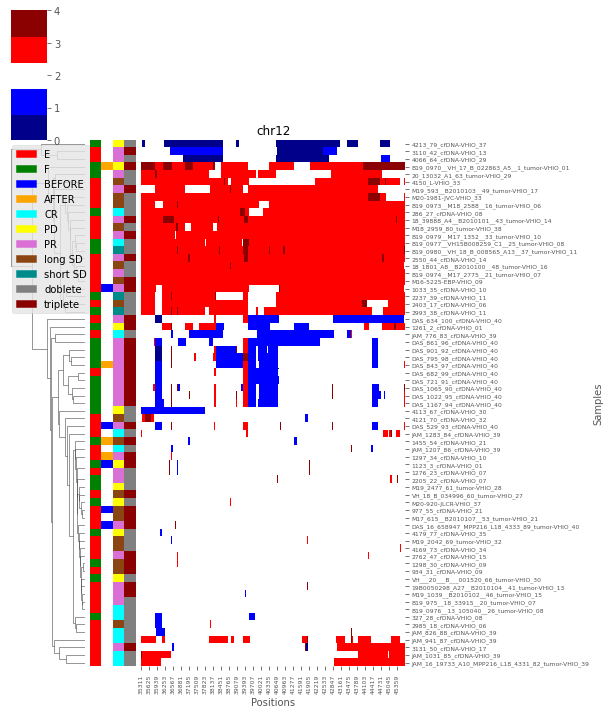

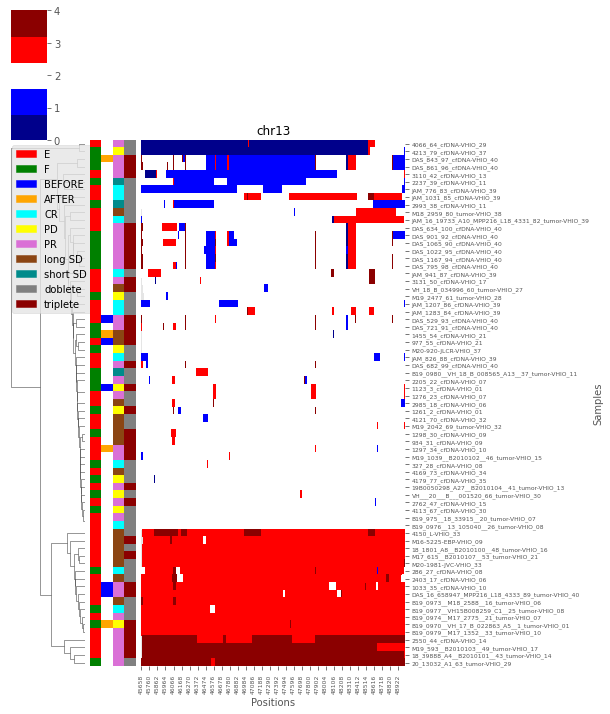

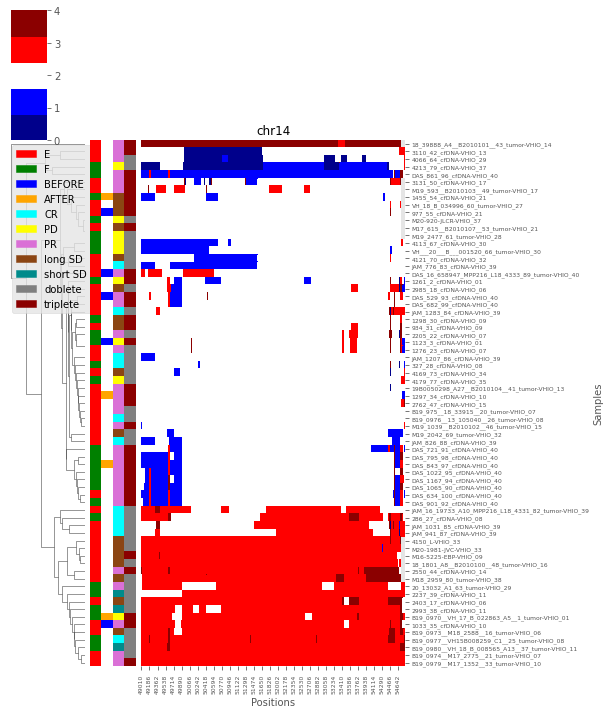

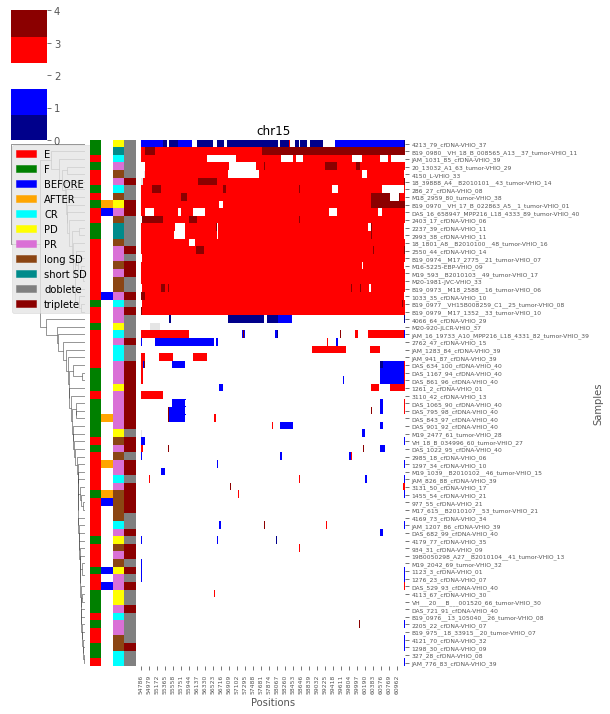

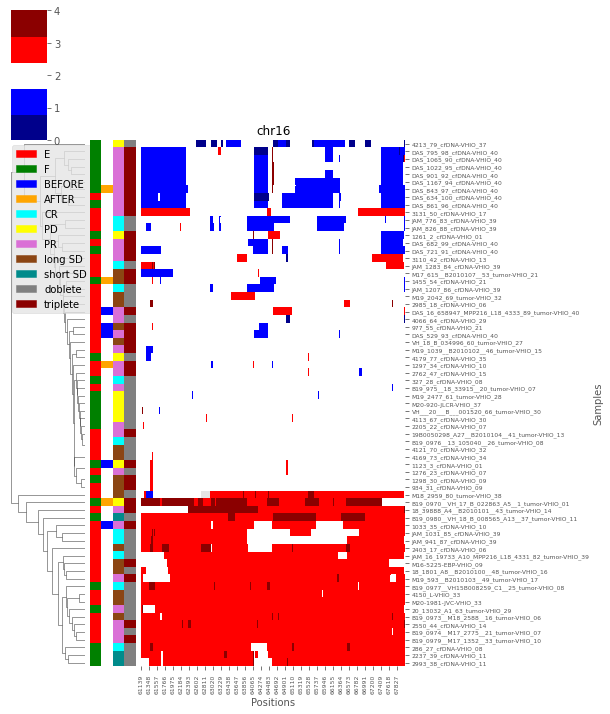

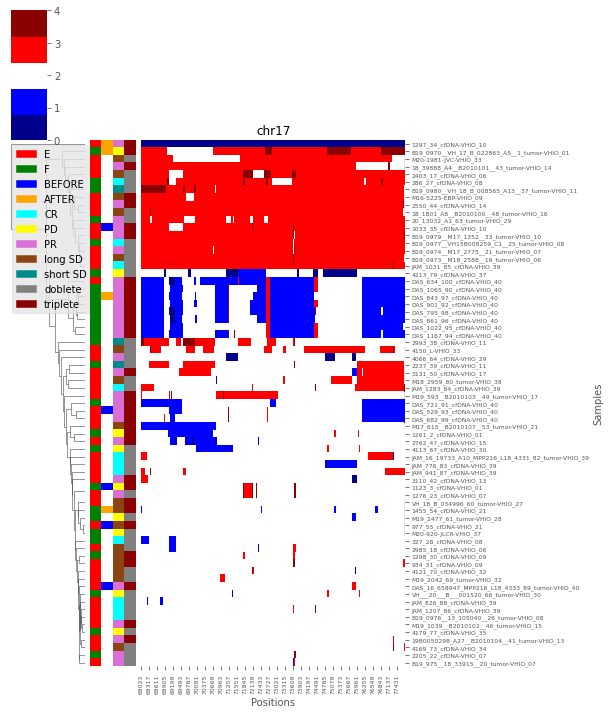

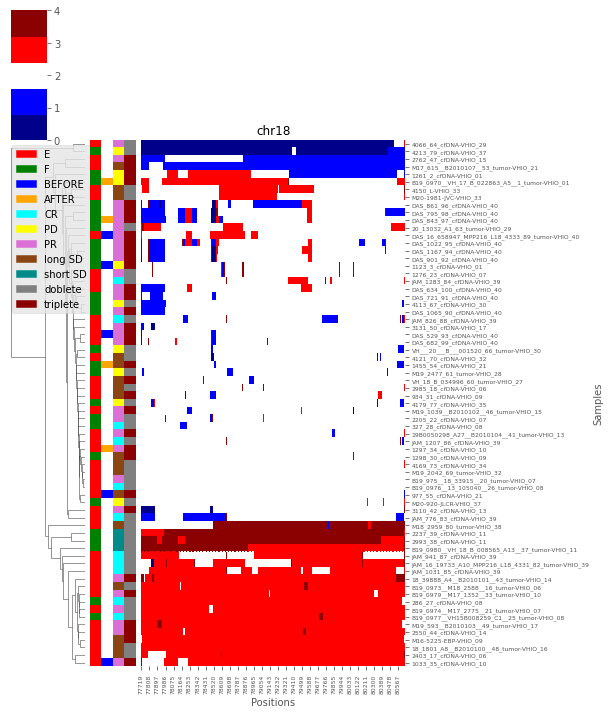

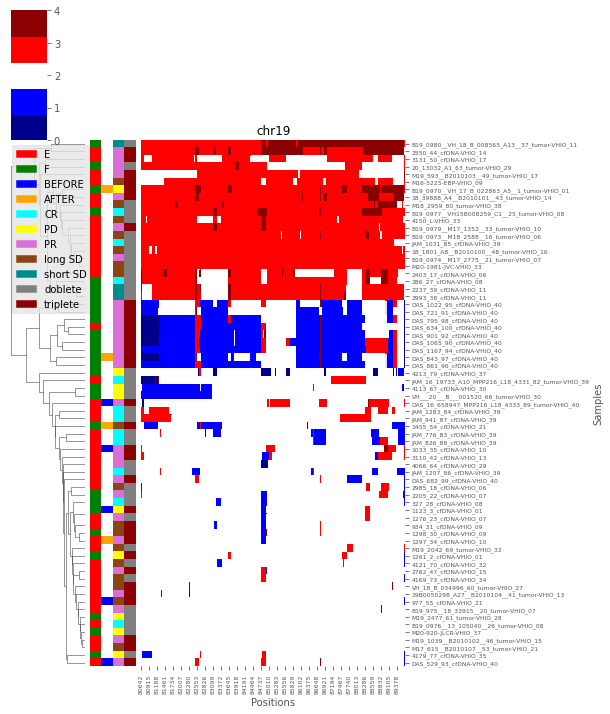

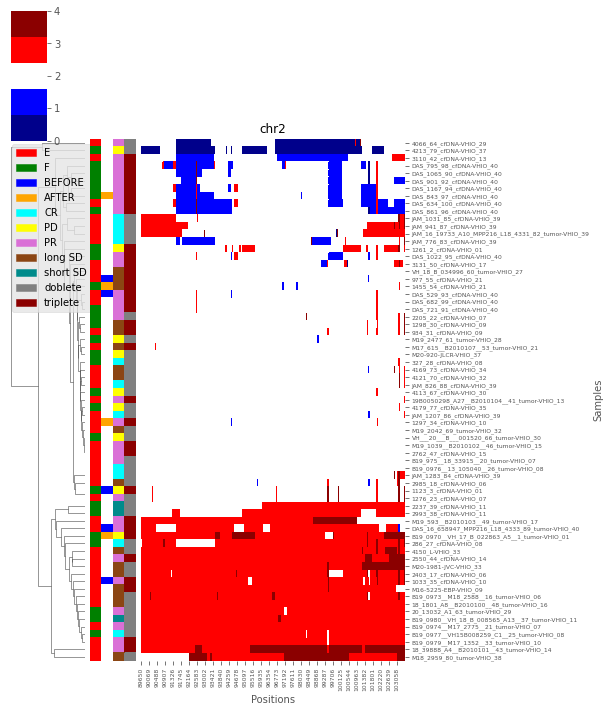

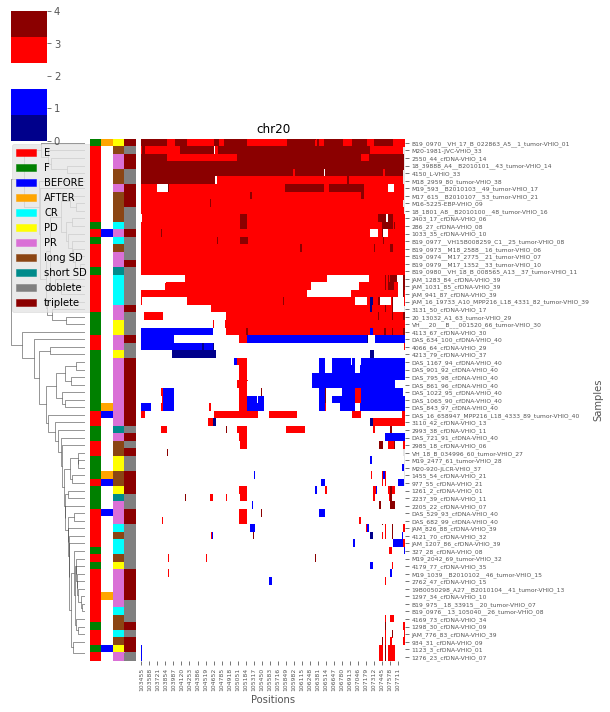

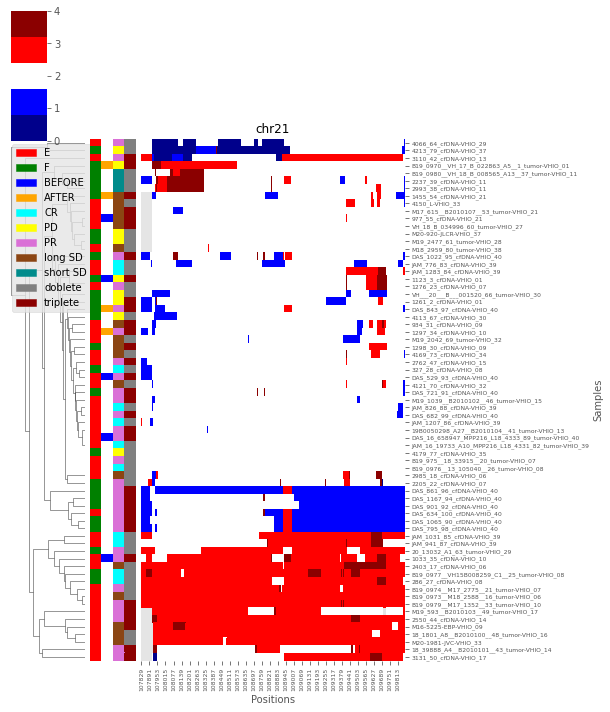

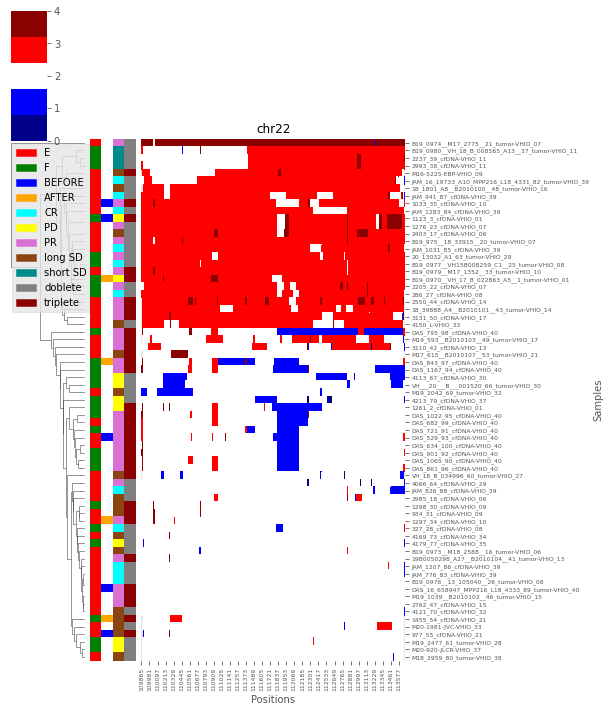

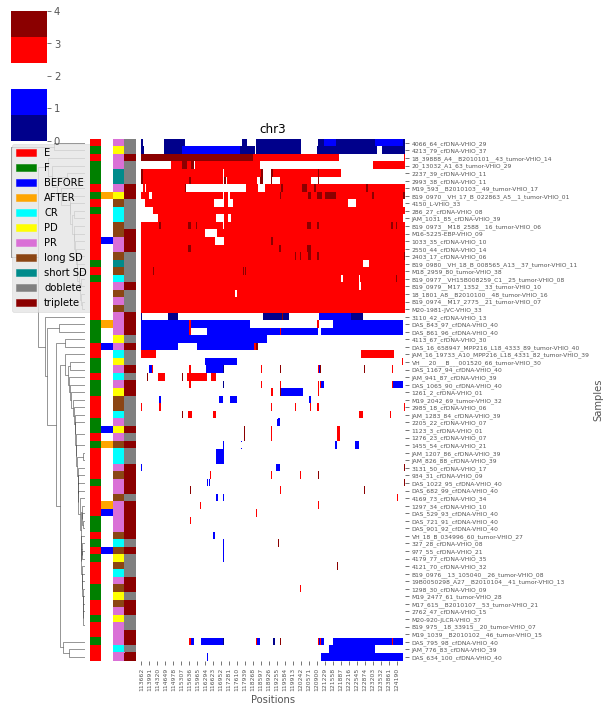

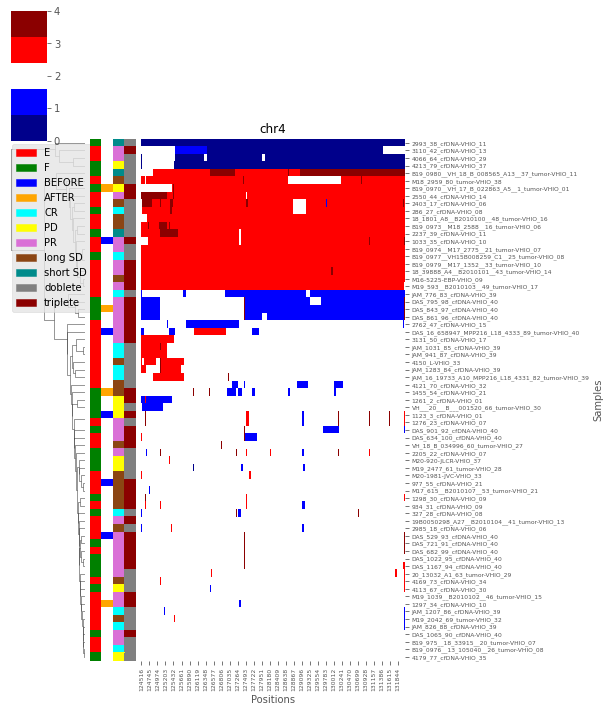

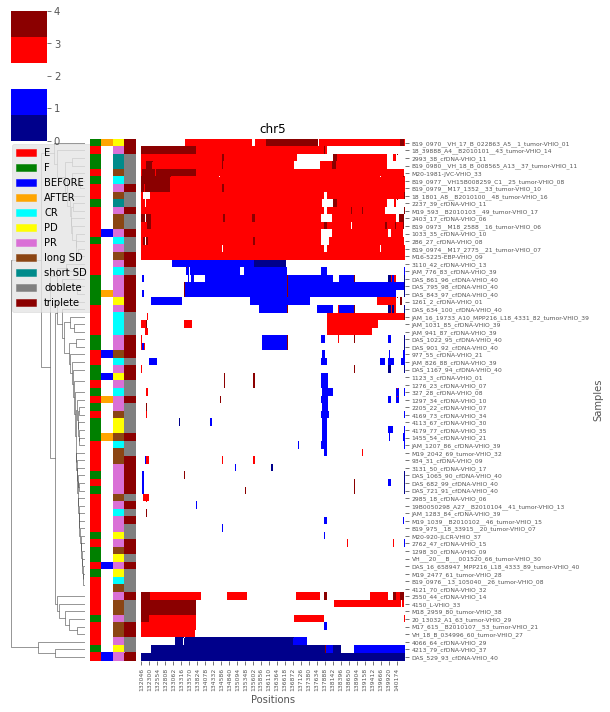

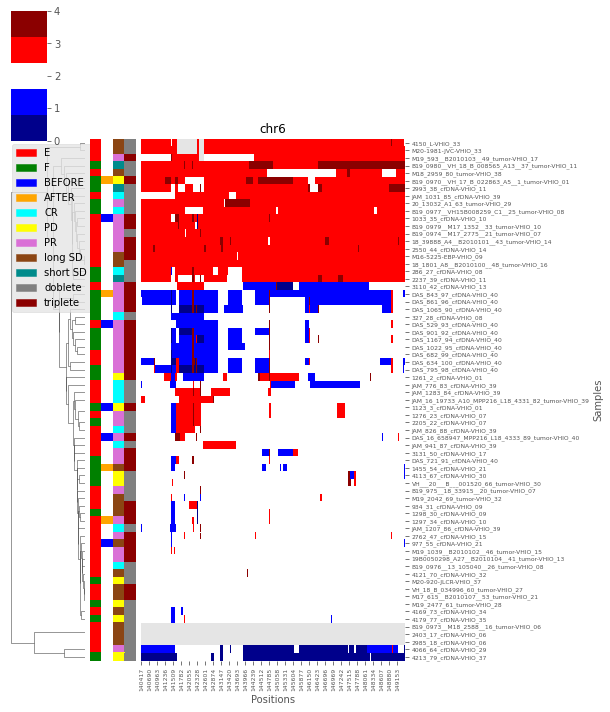

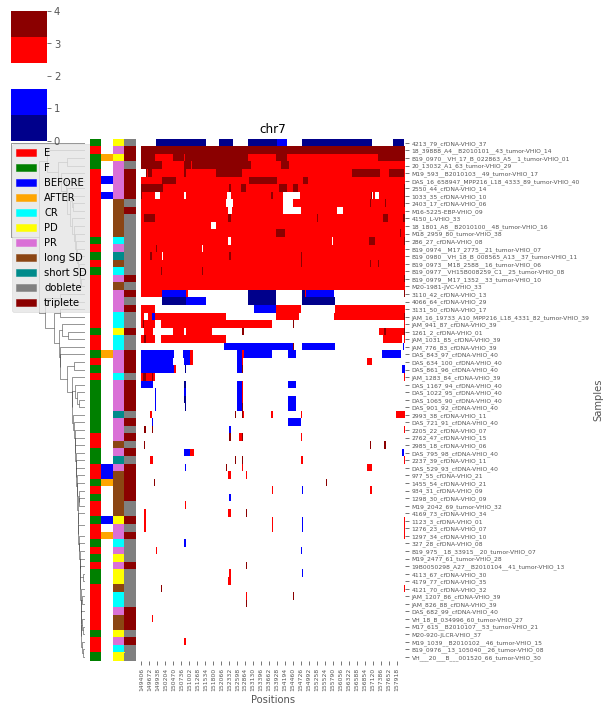

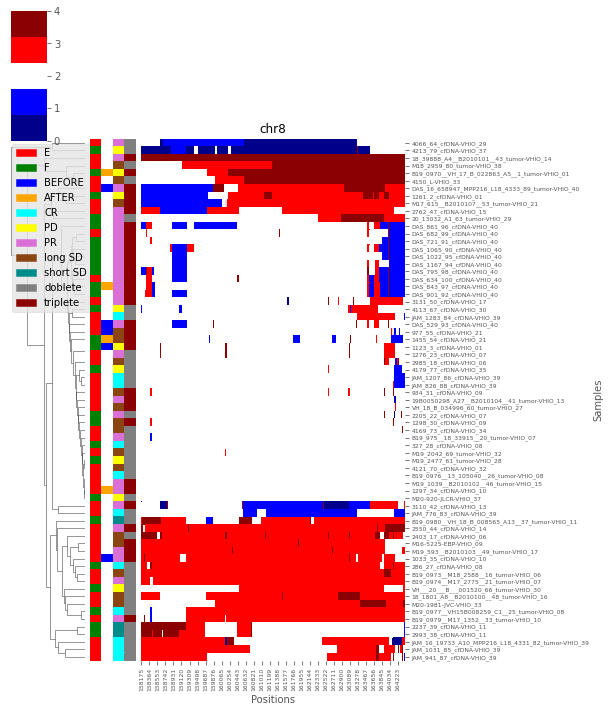

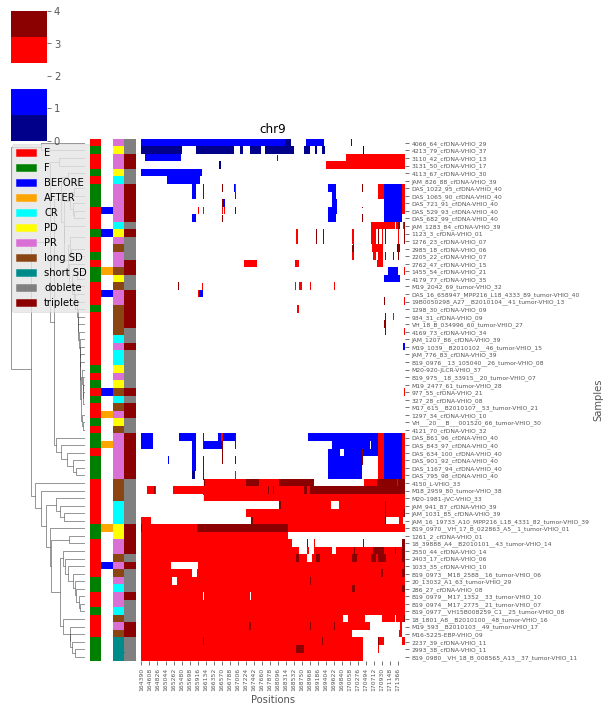

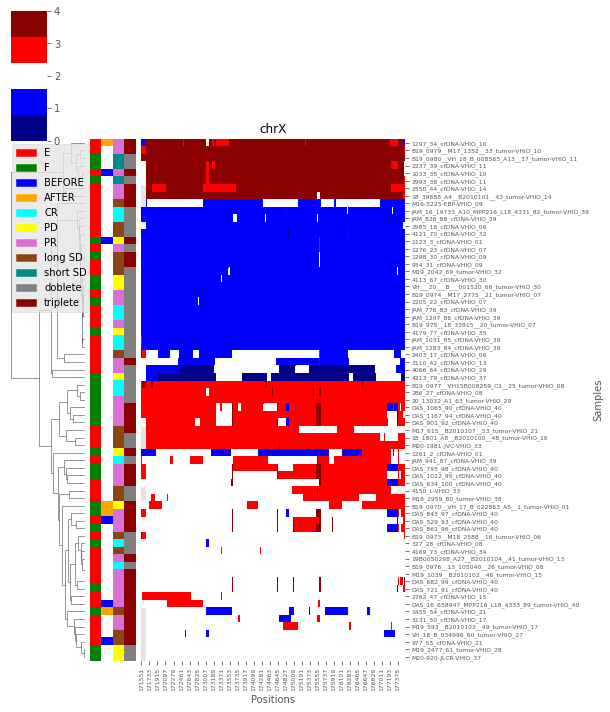

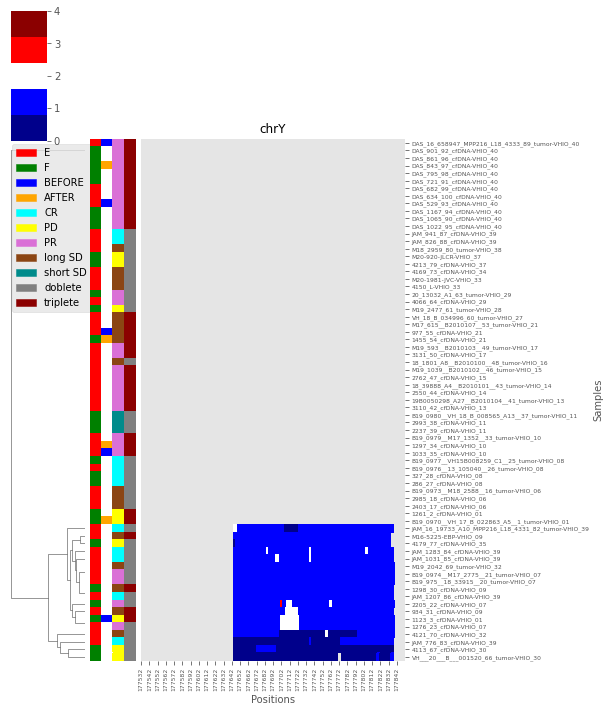

In [14]:
for name, group in cnvs.groupby('CHR', axis=0):
    data = group.iloc[:,3:].transpose()
    data[data == 'Na'] = np.nan
    data = data.astype('float')
    data[data < 0.0] = np.nan
    data[data > 3.0] = 4
    data = data.fillna(-1)
    plot_heatmap(data, meta_filtered, name, name + "_scaled.pdf", False, True, True)

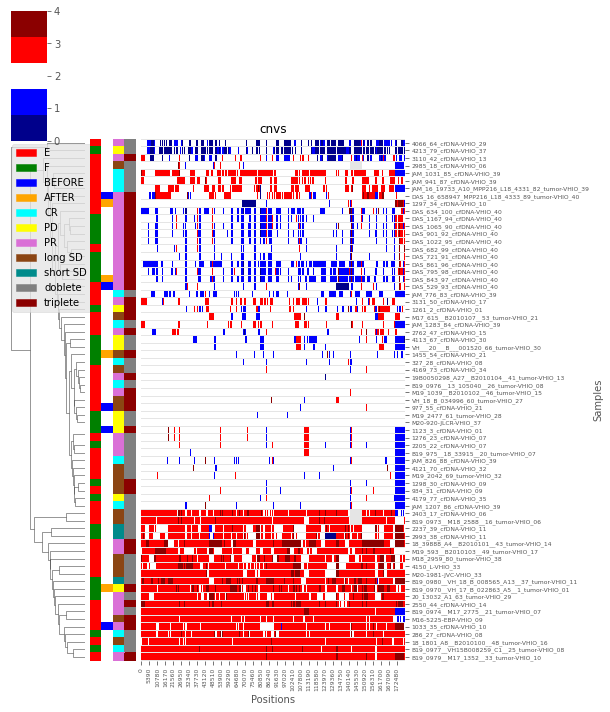

In [7]:
data = cnvs.iloc[:,3:].transpose()
data[data == 'Na'] = np.nan
data = data.astype('float')
data[data < 0.0] = np.nan
data[data > 3.0] = 4
data = data.fillna(-1)
name = 'cnvs'
plot_heatmap(data, meta_filtered, name, name + "_scaled.pdf", False, True, True)

In [ ]:
for name, group in cnvs.iloc[:,2:].groupby('GENE', axis=0):
    data = group.iloc[:,2:].transpose()
    data[data == 'Na'] = np.nan
    data = data.astype('float')
    data[data < 0.0] = np.nan
    data[data > 3.0] = 4
    data = data.fillna(-1)
    if name in ['MYC', 'MYCL', 'MET', 'EGFR', 'KRAS', 'BRAF']:
        plot_heatmap(data, meta_filtered, name, name + "_scaled.pdf", False, True, True)

(66, 23596)
(66, 37)


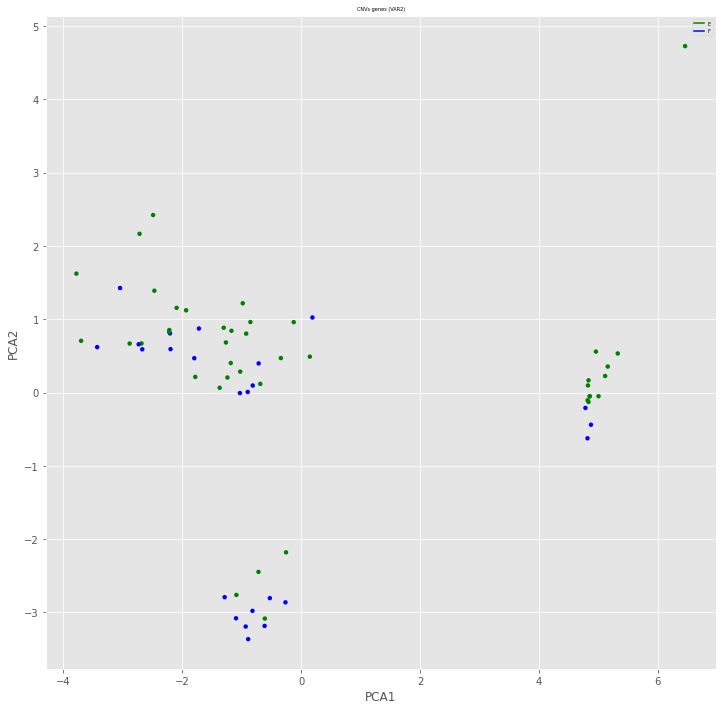

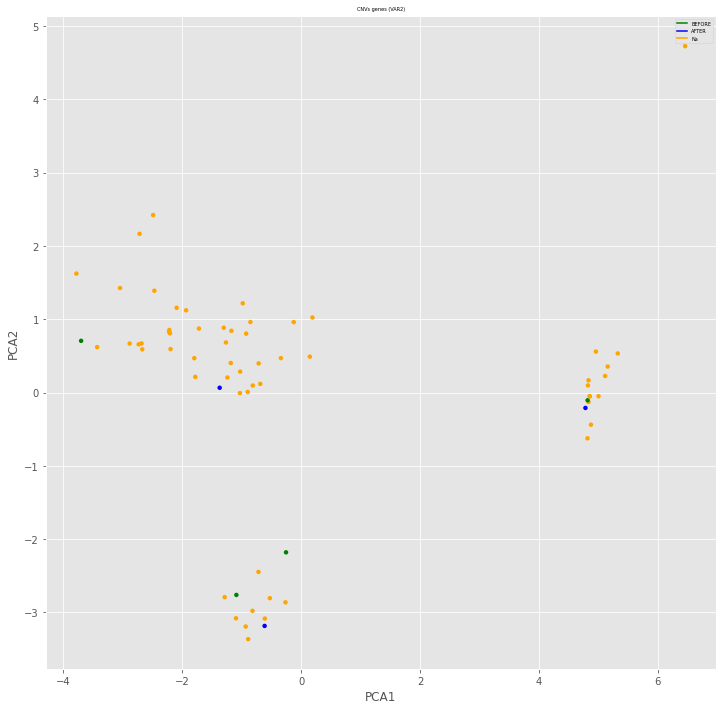

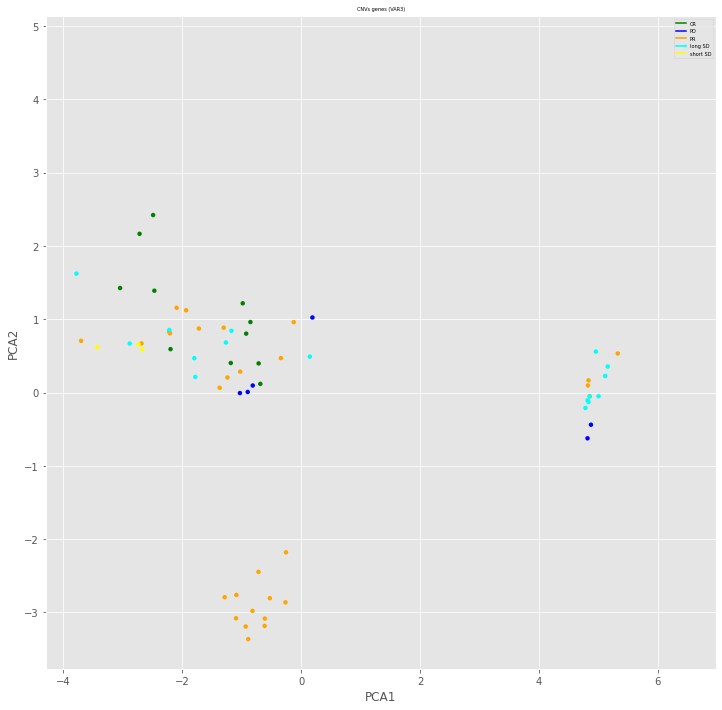

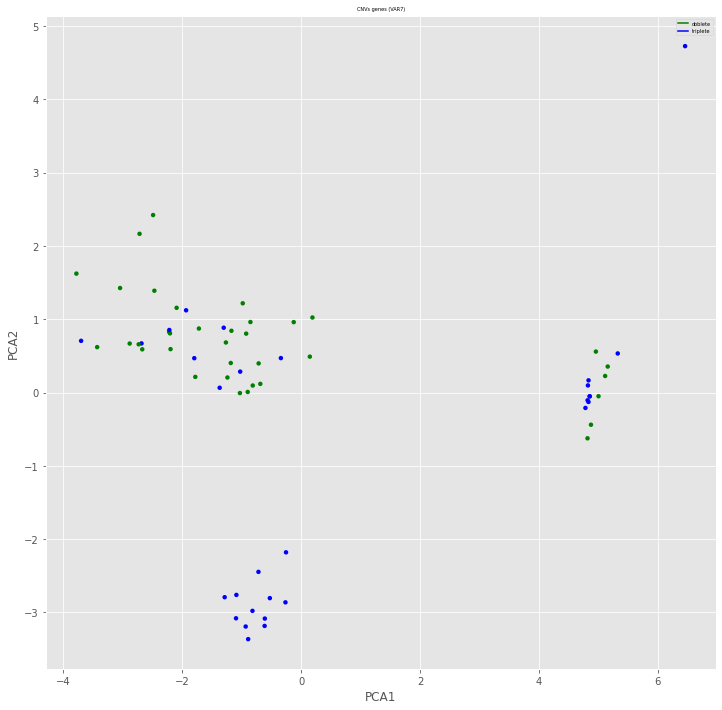

In [7]:
from sklearn.decomposition import KernelPCA
from sklearn.feature_selection import VarianceThreshold

data = cnvs_genes.iloc[:,3:].transpose()
meta = meta_filtered.reindex(data.index)
data[data == 'Na'] = np.nan
data = data.astype('float')
data[data < 0.0] = np.nan
data[data > 3.0] = 4
data = data.fillna(-1)
X = data
print(X.shape)
sel = VarianceThreshold(threshold=(0.3))
X_red = sel.fit_transform(X)
print(X_red.shape)
reduced_data = KernelPCA(kernel='linear', n_components=2).fit_transform(X_red)

labels = [1 if x == 'E' else 2 for x in meta['VAR2']]
plot_pca(x=reduced_data[:, 0], 
         y=reduced_data[:, 1], 
         colors=labels,
         labels=['E', 'F'],
         title='CNVs genes (VAR2)',
         filename='pca_var1.pdf')

labels = [1 if x == 'BEFORE' else 2 if x == 'AFTER' else 3 for x in meta['VAR1']]
plot_pca(x=reduced_data[:, 0], 
         y=reduced_data[:, 1], 
         colors=labels,
         labels=['BEFORE', 'AFTER', 'Na'],
         title='CNVs genes (VAR2)',
         filename='pca_var2.pdf')

var3 = meta['VAR3'].copy()
var3.loc[var3 == 'CR'] = 1
var3.loc[var3 == 'PD'] = 2
var3.loc[var3 == 'PR'] = 3
var3.loc[var3 == 'long SD'] = 4
var3.loc[var3 == 'short SD'] = 5
labels = ['CR', 'PD', 'PR', 'long SD', 'short SD']
plot_pca(x=reduced_data[:, 0], 
         y=reduced_data[:, 1], 
         colors=var3.to_list(),
         labels=labels,
         title='CNVs genes (VAR3)',
         filename='pca_var3.pdf')

var7 = meta['VAR7'].copy()
var7.loc[var7 == 'doblete'] = 1
var7.loc[var7 == 'triplete'] = 2
labels = ['doblete', 'triplete']
plot_pca(x=reduced_data[:, 0], 
         y=reduced_data[:, 1], 
         colors=var7.to_list(),
         labels=labels,
         title='CNVs genes (VAR7)',
         filename='pca_var7.pdf')